In [41]:
#import packages

import re 
import pickle


import pandas as pd
import numpy as np
import json

import pprint
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from collections import OrderedDict


from wordcloud import WordCloud


import gensim 
from gensim import corpora

In [3]:
#read in .josn files 
with open('data/yelp-dataset/yelp_academic_dataset_business.json') as fp: #请保持data/yelp-dataset/xxxx 的路径，方便交流
    lines = fp.readlines()

In [4]:
# Create dataframe
list_ = []
for i_line in lines:
    list_.append(json.loads(i_line))
df_business = pd.DataFrame(list_)
df_business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188593 entries, 0 to 188592
Data columns (total 15 columns):
address         188593 non-null object
attributes      162807 non-null object
business_id     188593 non-null object
categories      188052 non-null object
city            188593 non-null object
hours           143791 non-null object
is_open         188593 non-null int64
latitude        188587 non-null float64
longitude       188587 non-null float64
name            188593 non-null object
neighborhood    188593 non-null object
postal_code     188593 non-null object
review_count    188593 non-null int64
stars           188593 non-null float64
state           188593 non-null object
dtypes: float64(3), int64(2), object(10)
memory usage: 21.6+ MB


In [43]:
#filter cities and drop NaN
df_business = df_business[(df_business['city']=='Toronto')
                          | (df_business['city']=='Las Vegas')
                          | (df_business['city']=='Cleveland')
                          | (df_business['city']=='Montréal')]
print('with NaN', df_business.shape)
print('withou NaN', df_business.dropna().shape)
df_business.dropna(inplace=True)
print('Number of business', len(df_business['business_id'].unique()))
df_business.head(200)

with NaN (38117, 15)
withou NaN (38117, 15)
Number of business 38117


,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
2,1335 rue Beaubien E,"{'Alcohol': 'beer_and_wine', 'Ambience': '{'ro...",O8S5hYJ1SMc8fA4QBtVujA,"Breakfast & Brunch, Restaurants, French, Sandw...",Montréal,"{'Monday': '10:0-22:0', 'Tuesday': '10:0-22:0'...",0,45.540503,-73.599300,La Bastringue,Rosemont-La Petite-Patrie,H2G 1K7,5,4.0,QC
11,595 Markham Street,"{'Alcohol': 'full_bar', 'Ambience': '{'romanti...",tZnSodhPwNr4bzrwJ1CSbw,"Cajun/Creole, Southern, Restaurants",Toronto,"{'Tuesday': '17:0-1:0', 'Wednesday': '17:0-1:0...",0,43.664125,-79.411886,Southern Accent Restaurant,Palmerston,M6G 2L7,146,4.0,ON
16,438 Place Jacques Cartier,"{'Alcohol': 'full_bar', 'BikeParking': 'True',...",r89Re4FNgVWHgBfjCVZyVw,"Nightlife, Bars, American (Traditional), Tapas...",Montréal,"{'Monday': '11:30-23:0', 'Tuesday': '11:30-23:...",0,45.507699,-73.553407,Harlow,Ville-Marie,H2Y 3B3,12,3.5,QC
19,"3940 Martin Luther King Blvd, Ste 101","{'BikeParking': 'True', 'BusinessAcceptsCredit...",vJIuDBdu01vCA8y1fwR1OQ,"American (Traditional), Food, Bakeries, Restau...",Las Vegas,"{'Tuesday': '11:0-18:0', 'Wednesday': '11:0-18...",0,36.192284,-115.159272,CakesbyToi,,89106,3,1.5,NV
23,746 Street Clair Avenue W,"{'BikeParking': 'True', 'BusinessAcceptsCredit...",5J3b7j3Fzo9ISjChmoUoUA,"Food, Bakeries, Coffee & Tea",Toronto,"{'Monday': '7:30-19:0', 'Tuesday': '7:30-19:0'...",1,43.681328,-79.427884,Mabel's Bakery,Wychwood,M6C 1B5,23,4.0,ON
32,2255 N Rampart Blvd,"{'Alcohol': 'none', 'Ambience': '{'romantic': ...",kgffcoxT6BQp-gJ-UQ7Czw,"Fast Food, Restaurants, Sandwiches",Las Vegas,"{'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...",1,36.201794,-115.281981,Subway,Summerlin,89128,13,2.5,NV
33,2227 N Rampart Blvd,"{'Alcohol': 'beer_and_wine', 'Ambience': '{'ro...",0jtRI7hVMpQHpUVtUy4ITw,"Beer, Wine & Spirits, Italian, Food, American ...",Las Vegas,"{'Monday': '7:0-14:30', 'Tuesday': '7:0-19:0',...",1,36.201990,-115.283122,Omelet House Summerlin,Summerlin,89128,242,4.0,NV
37,15828 Euclid Ave,"{'Alcohol': 'none', 'Ambience': '{'romantic': ...",qHF2s8U2yzPLgIOGH_IMBw,"Seafood, Restaurants",Cleveland,"{'Monday': '10:0-23:0', 'Tuesday': '10:0-23:0'...",1,41.541571,-81.569901,John John's Seafood,Collamer,44112,3,4.5,OH
44,"2101 S Decatur Blvd, Ste 11","{'BikeParking': 'True', 'BusinessAcceptsCredit...",0i6GlR5YTCMlwthjqw6ZTQ,"Hair Salons, Beauty & Spas",Las Vegas,"{'Monday': '10:0-19:0', 'Tuesday': '10:0-19:0'...",1,36.148658,-115.209813,Cinthya's Beauty Salon,Westside,89102,16,4.5,NV
45,"3111 S Valley View Blvd, Unit B120","{'BusinessAcceptsCreditCards': 'True', 'ByAppo...",oSS0p8TeF9BTTD7QWtO6gg,"Flooring, Cabinetry, Refinishing Services, Hom...",Las Vegas,"{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...",1,36.131640,-115.190826,Aria Remodeling,Westside,89102,3,5.0,NV


In [6]:
# output filtered dataframe to binary files as pickles, so that one may use it to filter out dataset
with open('data/yelp-dataset/df_business.pickle', 'wb') as fp:
    pickle.dump(df_business[['business_id', 'city', 'categori'],fp)

In [47]:
text_business_cate=' '.join(df_business['categories'])
# get_text_ready(text_business_cate)
len(text_business_cate)//8


272473

In [50]:
from multiprocessing import Pool

def get_text_ready(i):
    t_i = 't'+ i
    
    global text_business_cate
    text_dict = {'t1':text_business_cate[        :272473*1],
                't2':text_business_cate[272473*1:272473*2],
                't3':text_business_cate[272473*2:272473*3],
                't4':text_business_cate[272473*3:272473*4],
                't5':text_business_cate[272473*4:272473*5],
                't6':text_business_cate[272473*5:272473*6],
                't7':text_business_cate[272473*6:272473*7],
                't8':text_business_cate[272473*7:        ]}
    
    text = text_dict[t_i] 
    striptext = text.replace('\n\n', ' ')
    striptext = striptext.replace('\n', ' ')
    words = word_tokenize(striptext)
    lowercase_words = {word.lower() for word in words
                      if word not in stopwords.words() and word.isalpha()}
    return lowercase_words



if __name__ == '__main__':
    
    with Pool(processes=8) as pool:
        r1 = pool.apply_async(get_text_ready, ('1'))
        r2 = pool.apply_async(get_text_ready, ('2'))
        r3 = pool.apply_async(get_text_ready, ('3'))
        r4 = pool.apply_async(get_text_ready, ('4'))
        r5 = pool.apply_async(get_text_ready, ('5'))
        r6 = pool.apply_async(get_text_ready, ('6'))
        r7 = pool.apply_async(get_text_ready, ('7'))
        r8 = pool.apply_async(get_text_ready, ('8'))
#         print(r1.get(timeout=600)[:2])
#         print(r2.get(timeout=600)[:2])
#         print(r3.get(timeout=600)[:2])
        list_ = []
        for r in [r1, r2, r3, r4, r5, r6, r7, r8]:
            list_.extend(r.get(timeout=600))
        df = pd.DataFrame(list_)

In [105]:
lemmatizer_ = WordNetLemmatizer()
lemmatizer_.lemmatize('telecommunications')

'telecommunication'

In [54]:
df.shape

(7420, 1)

In [107]:
df[0] = df[0].apply(lambda x: lemmatizer_.lemmatize(x))
df.head()


,0,food
0,trainer,False
1,vintage,False
2,aquarium,False
3,museum,False
4,loss,False


In [108]:
df[0].value_counts().head(8)

bike      16
watch     16
team      16
pool      16
office    16
art       16
video     16
rental    16
Name: 0, dtype: int64

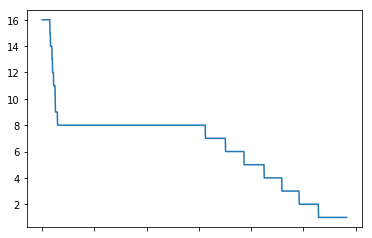

In [109]:
df[0].value_counts().plot(kind='line')

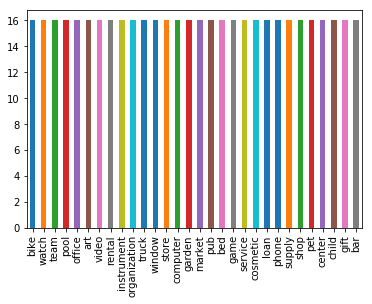

In [110]:
df[0].value_counts().iloc[:30].plot(kind='bar')

In [88]:
# import requests
# from bs4 import BeautifulSoup

# respones = requests.get('https://www.enchantedlearning.com/wordlist/restaurant.shtml')
# Soup = BeautifulSoup(respones.content.decode('utf-8'))
# word_tags = Soup.findAll('div',attrs={'class':'wordlist-item'})
# restaurants = []
# for tag in word_tags:
#     restaurants.append(tag.get_text())
# restaurants.extend(['food', 'pizza', 'restaurant'])
set(restaurants)

{'French fries',
 'a la carte',
 'a la mode',
 'appetizer',
 'beef',
 'beverage',
 'bill',
 'bistro',
 'boiled',
 'bowl',
 'braised',
 'bread',
 'breakfast',
 'brunch',
 'butter',
 'cafe',
 'cafeteria',
 'cake',
 'candle',
 'cashier',
 'centerpiece',
 'chair',
 'charge',
 'chef',
 'chicken',
 'coffee',
 'cola',
 'cold',
 'condiments',
 'cook',
 'cooked',
 'course',
 'cream',
 'credit card',
 'cutlery',
 'deli',
 'delicatessen',
 'delicious',
 'dessert',
 'dine',
 'diner',
 'dining',
 'dinner',
 'dish',
 'dishwasher',
 'doggie bag',
 'dressing',
 'eat',
 'eggs',
 'entree',
 'fish',
 'food',
 'fork',
 'fries',
 'fruit',
 'glass',
 'gourmand',
 'gourmet',
 'grilled',
 'hamburger',
 'head waiter',
 'high tea',
 "hors d'oeuvre",
 'hostess',
 'hot',
 'ice',
 'ice cubes',
 'iced',
 'ingredients',
 'ketchup',
 'kitchen',
 'knife',
 'lemonade',
 'lettuce',
 'lunch',
 'main course',
 "maitre d'",
 'manager',
 'meal',
 'meat',
 'medium',
 'menu',
 'milk',
 'mug',
 'mustard',
 'napkin',
 'noodles'

In [114]:
df['food'] = df[0].isin(restaurants)
df[df['food']==True][0].value_counts()

restaurant      14
medium          12
cafe             9
coffee           8
glass            8
kitchen          8
party            8
bistro           8
pizza            8
chicken          8
cake             8
seafood          8
salad            8
fish             8
water            8
dessert          8
delicatessen     8
diner            8
meat             8
hot              8
cream            8
brunch           8
sandwich         8
fruit            8
chef             8
food             8
soup             8
tea              8
breakfast        8
ice              8
deli             8
plate            8
course           7
bowl             7
pasta            7
knife            7
special          6
dinner           6
tax              6
cafeteria        3
server           2
supper           2
beverage         2
Name: 0, dtype: int64

In [119]:
food_filter = []
food_filter.append(df[df['food']==True][0])
food_filter

[23               ice
 31        restaurant
 40             water
 54            brunch
 68          beverage
 80             pizza
 93              food
 107          chicken
 127            pasta
 129            plate
 148             cafe
 165              tea
 191            glass
 219             chef
 239             fish
 259           dinner
 267        breakfast
 284            party
 293           course
 298              tax
 330           bistro
 361             soup
 378           coffee
 420            cream
 426           medium
 439            fruit
 457          kitchen
 460              hot
 478             meat
 538       restaurant
             ...     
 6673           glass
 6700            chef
 6717            fish
 6720            cafe
 6738          dinner
 6746       breakfast
 6765           party
 6774          course
 6780             tax
 6815          bistro
 6848            soup
 6863          coffee
 6902           cream
 6909          medium
 6926     

<WordNetLemmatizer>

In [145]:
df_business.drop(labels='cc',axis=1,inplace=True)
# df_business['cc'] = None
# def Create_df_cate_ready(i,j):
#     global df_business
    
#     def get_text_ready(text):
#         striptext = text.replace('\n\n', ' ')
#         striptext = striptext.replace('\n', ' ')
#         words = word_tokenize(striptext)
#         lemmatizer_ = WordNetLemmatizer()
#         lowercase_words = [lemmatizer_.lemmatize(word.lower()) for word in words
#                           if word not in stopwords.words() and word.isalpha()]
#         return lowercase_words
#     df_business['cc'].iloc[i:j] = df_business['categories'].iloc[i:j].apply(get_text_ready)
# Create_df_cate_ready(0,5)
# df_business.head(9)

In [148]:
df_business.shape[0]//8

4764

In [198]:
from multiprocessing import Pool
df_business['categories_ready'] = None
def Create_df_cate_ready(i,j):
    global df_business
#     df_business['categories_ready'] = None
    
    def get_text_ready(text):
        striptext = text.replace('\n\n', ' ')
        striptext = striptext.replace('\n', ' ')
        words = word_tokenize(striptext)
        lemmatizer_ = WordNetLemmatizer()
        lowercase_words = [lemmatizer_.lemmatize(word.lower()) for word in words
                          if word not in stopwords.words() and word.isalpha()]
        return lowercase_words
 
    return pd.DataFrame(df_business['categories'].iloc[i:j].apply(get_text_ready))

if __name__ == '__main__':
    
    num = df_business.shape[0]//8
    with Pool(processes=8) as pool:
        r1 = pool.apply_async(Create_df_cate_ready,(None ,num*1))
        r2 = pool.apply_async(Create_df_cate_ready,(num*1,num*2))
        r3 = pool.apply_async(Create_df_cate_ready,(num*2,num*3))
        r4 = pool.apply_async(Create_df_cate_ready,(num*3,num*4))
        r5 = pool.apply_async(Create_df_cate_ready,(num*4,num*5))
        r6 = pool.apply_async(Create_df_cate_ready,(num*5,num*6))
        r7 = pool.apply_async(Create_df_cate_ready,(num*6,num*7))
        r8 = pool.apply_async(Create_df_cate_ready,(num*7, None))
        

#         list_ = []
#         for r in [r1, r2, r3, r4, r5, r6, r7, r8]:
#             list_.extend(r.get(timeout=600))
#         df_cate_ready = pd.DataFrame(list_)
r1.get().append(r2.get()).shape

                                            categories
2    [breakfast, brunch, restaurant, french, sandwi...
11                              [southern, restaurant]
16   [nightlife, bar, american, traditional, plate,...
19   [american, traditional, food, bakery, restaurant]
23                         [food, bakery, coffee, tea]
32                  [fast, food, restaurant, sandwich]
33   [beer, wine, spirit, italian, food, american, ...
37                               [seafood, restaurant]
44                          [hair, salon, beauty, spa]
45   [flooring, cabinetry, refinishing, service, ho...
50   [thrift, store, shopping, used, vintage, consi...
52   [motorcycle, rental, active, life, motorcycle,...
80               [caribbean, food, bakery, restaurant]
82                                      [food, bakery]
88   [restaurant, food, coffee, tea, breakfast, bru...
95                                      [food, bakery]
96                               [drugstore, shopping]
97     [ni

(20, 1)

In [181]:
df_business.head(30)

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state,categories_ready
2,1335 rue Beaubien E,"{'Alcohol': 'beer_and_wine', 'Ambience': '{'ro...",O8S5hYJ1SMc8fA4QBtVujA,"Breakfast & Brunch, Restaurants, French, Sandw...",Montréal,"{'Monday': '10:0-22:0', 'Tuesday': '10:0-22:0'...",0,45.540503,-73.599300,La Bastringue,Rosemont-La Petite-Patrie,H2G 1K7,5,4.0,QC,None
11,595 Markham Street,"{'Alcohol': 'full_bar', 'Ambience': '{'romanti...",tZnSodhPwNr4bzrwJ1CSbw,"Cajun/Creole, Southern, Restaurants",Toronto,"{'Tuesday': '17:0-1:0', 'Wednesday': '17:0-1:0...",0,43.664125,-79.411886,Southern Accent Restaurant,Palmerston,M6G 2L7,146,4.0,ON,None
16,438 Place Jacques Cartier,"{'Alcohol': 'full_bar', 'BikeParking': 'True',...",r89Re4FNgVWHgBfjCVZyVw,"Nightlife, Bars, American (Traditional), Tapas...",Montréal,"{'Monday': '11:30-23:0', 'Tuesday': '11:30-23:...",0,45.507699,-73.553407,Harlow,Ville-Marie,H2Y 3B3,12,3.5,QC,None
19,"3940 Martin Luther King Blvd, Ste 101","{'BikeParking': 'True', 'BusinessAcceptsCredit...",vJIuDBdu01vCA8y1fwR1OQ,"American (Traditional), Food, Bakeries, Restau...",Las Vegas,"{'Tuesday': '11:0-18:0', 'Wednesday': '11:0-18...",0,36.192284,-115.159272,CakesbyToi,,89106,3,1.5,NV,None
23,746 Street Clair Avenue W,"{'BikeParking': 'True', 'BusinessAcceptsCredit...",5J3b7j3Fzo9ISjChmoUoUA,"Food, Bakeries, Coffee & Tea",Toronto,"{'Monday': '7:30-19:0', 'Tuesday': '7:30-19:0'...",1,43.681328,-79.427884,Mabel's Bakery,Wychwood,M6C 1B5,23,4.0,ON,None
32,2255 N Rampart Blvd,"{'Alcohol': 'none', 'Ambience': '{'romantic': ...",kgffcoxT6BQp-gJ-UQ7Czw,"Fast Food, Restaurants, Sandwiches",Las Vegas,"{'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...",1,36.201794,-115.281981,Subway,Summerlin,89128,13,2.5,NV,None
33,2227 N Rampart Blvd,"{'Alcohol': 'beer_and_wine', 'Ambience': '{'ro...",0jtRI7hVMpQHpUVtUy4ITw,"Beer, Wine & Spirits, Italian, Food, American ...",Las Vegas,"{'Monday': '7:0-14:30', 'Tuesday': '7:0-19:0',...",1,36.201990,-115.283122,Omelet House Summerlin,Summerlin,89128,242,4.0,NV,None
37,15828 Euclid Ave,"{'Alcohol': 'none', 'Ambience': '{'romantic': ...",qHF2s8U2yzPLgIOGH_IMBw,"Seafood, Restaurants",Cleveland,"{'Monday': '10:0-23:0', 'Tuesday': '10:0-23:0'...",1,41.541571,-81.569901,John John's Seafood,Collamer,44112,3,4.5,OH,None
44,"2101 S Decatur Blvd, Ste 11","{'BikeParking': 'True', 'BusinessAcceptsCredit...",0i6GlR5YTCMlwthjqw6ZTQ,"Hair Salons, Beauty & Spas",Las Vegas,"{'Monday': '10:0-19:0', 'Tuesday': '10:0-19:0'...",1,36.148658,-115.209813,Cinthya's Beauty Salon,Westside,89102,16,4.5,NV,None
45,"3111 S Valley View Blvd, Unit B120","{'BusinessAcceptsCreditCards': 'True', 'ByAppo...",oSS0p8TeF9BTTD7QWtO6gg,"Flooring, Cabinetry, Refinishing Services, Hom...",Las Vegas,"{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...",1,36.131640,-115.190826,Aria Remodeling,Westside,89102,3,5.0,NV,None


In [179]:
l = [1,2,3]
s ={3}
any(l)==any(s)

True

In [10]:

type(df_business['attributes'].iloc[0])

dict

In [13]:
df_business['attributes'].iloc[8]

{'BikeParking': 'True',
 'BusinessAcceptsCreditCards': 'True',
 'BusinessParking': "{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}",
 'ByAppointmentOnly': 'False',
 'GoodForKids': 'True',
 'RestaurantsPriceRange2': '1',
 'WheelchairAccessible': 'True'}

In [7]:
df_business.groupby('city').count().sort_values(by='stars', ascending=False)

,address,attributes,business_id,categories,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
city,,,,,,,,,,,,,,
Las Vegas,19613,19613,19613,19613,19613,19613,19613,19613,19613,19613,19613,19613,19613,19613
Toronto,12156,12156,12156,12156,12156,12156,12156,12156,12156,12156,12156,12156,12156,12156
Montréal,4147,4147,4147,4147,4147,4147,4147,4147,4147,4147,4147,4147,4147,4147
Cleveland,2201,2201,2201,2201,2201,2201,2201,2201,2201,2201,2201,2201,2201,2201


In [56]:
type(df_business.hours.iloc[0])

dict

In [50]:
df_business.hours.iloc[0]

{'Monday': '10:0-22:0',
 'Tuesday': '10:0-22:0',
 'Wednesday': '10:0-22:0',
 'Thursday': '10:0-22:0',
 'Friday': '10:0-22:0',
 'Saturday': '10:0-22:0',
 'Sunday': '10:0-22:0'}

#data cleanning...